# Convolutional Neural Networks for Image Classification
## Vendor and Magnetic Field Strenght Classification of Magnetic Resonance Images

Data for this demo can be downlaoded here: https://drive.google.com/file/d/1mHRcFslRhgsmvByBLPyg67quUm59DWyC/view?usp=sharing

Learning goal:
- Illustrate the use of convolutional neural networks for image classification. 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D,MaxPooling2D,Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
# Loading data
samples = np.load("../Data/CC-359-demo/cc_samples.npy")
field_labels = np.load("../Data/CC-359-demo/magnetic_field_labels.npy").astype(int)
vendor_labels = np.load("../Data/CC-359-demo/scanner_vendor_labels.npy").astype(int) 
age_labels = np.load("../Data/CC-359-demo/age_labels.npy")
labels = 3*field_labels + vendor_labels # combined vendor + field label - labels go from 0 to 5

# Shuffling samples
indexes = np.arange(samples.shape[0],dtype = int)
np.random.shuffle(indexes)
samples = samples[indexes]
field_labels = field_labels[indexes]
vendor_labels = vendor_labels[indexes]
age_labels = age_labels[indexes]
labels = labels[indexes]

# Labels mapping
field_dic = {"0":"1.5 T","1":"3 T"}
vendor_dic = {"0":"Philips","1":"GE","2":"Siemens"}

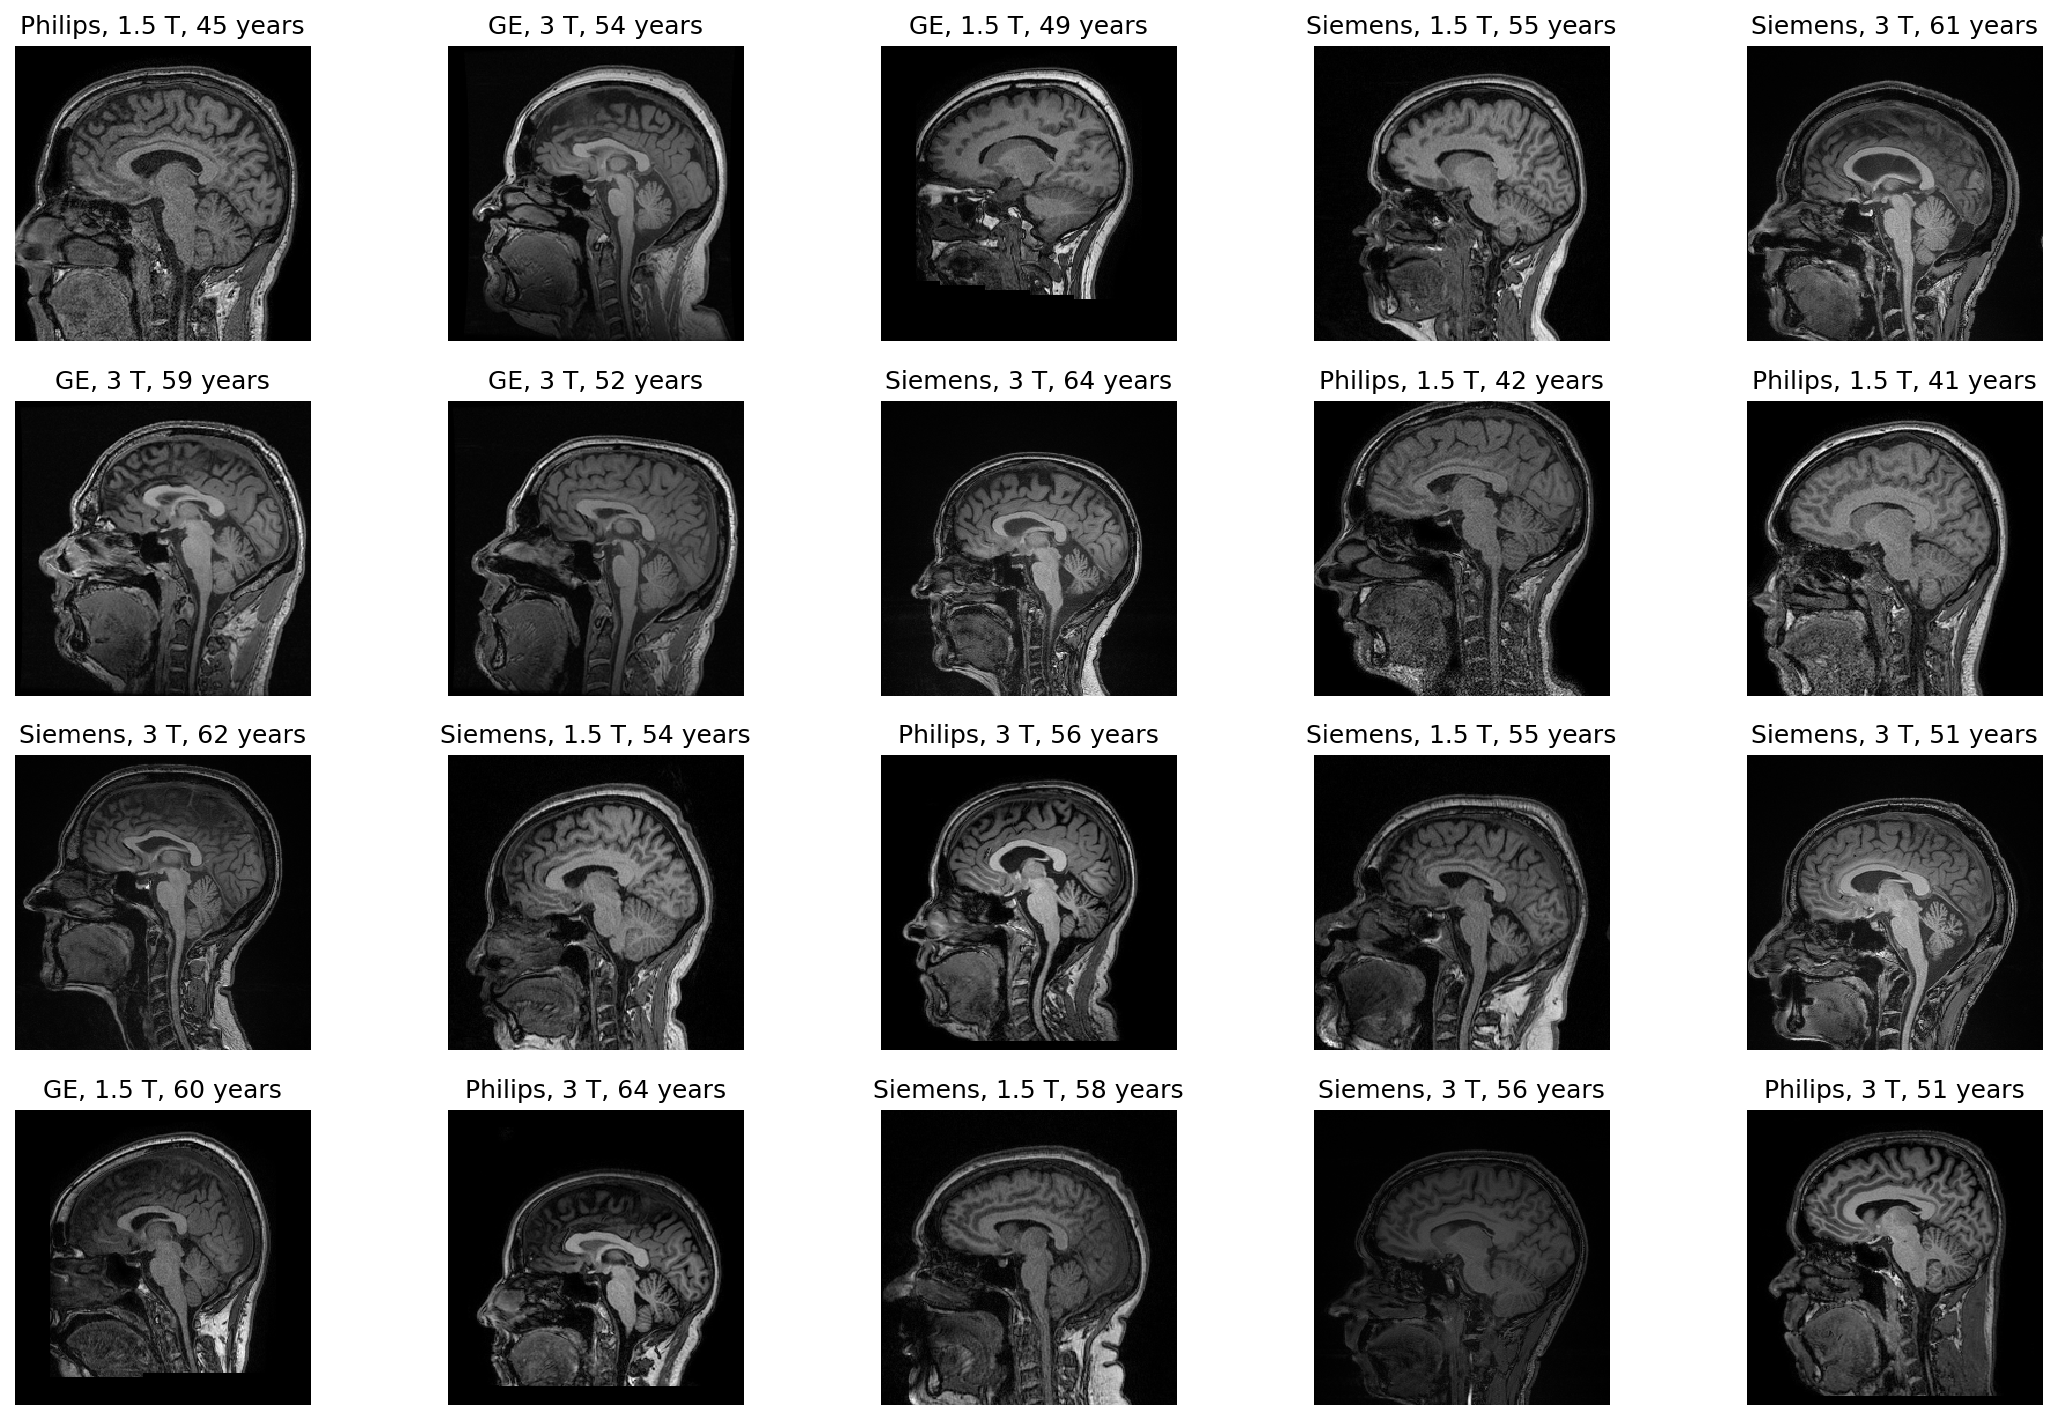

In [6]:
# Display some samples
skip = 180
plt.figure(dpi = 150, figsize = (18,12))
for ii in range(20):
    plt.subplot(4,5,ii+1)
    plt.imshow(samples[ii*skip],cmap = "gray")
    plt.axis("off")
    plt.title("%s, %s, %d years" %(vendor_dic[str(vendor_labels[ii*skip])],field_dic[str(field_labels[ii*skip])],\
              age_labels[ii*skip]))
plt.show()

In [7]:
# STratified splitting into train/test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(samples,labels)
train_index, test_index = next(sss.split(samples,labels))

samples_train = samples[train_index]
labels_train = labels[train_index] 
field_labels_train = field_labels[train_index]
vendor_labels_train = vendor_labels[train_index]
age_labels_train = age_labels[train_index]



samples_test = samples[test_index]
labels_test = labels[test_index] 
field_labels_test = field_labels[test_index]
vendor_labels_test = vendor_labels[test_index]
age_labels_test = age_labels[test_index]

# One-hot-encoding -is the format used as input when training the network
labels_train = tf.keras.utils.to_categorical(labels_train, 6)

In [8]:
# Our model
def my_model(input_shape):
    input_signal = Input(input_shape)
    
    # First block
    conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(input_signal)
    conv1 = Conv2D(32,kernel_size=(3,3),activation="relu")(conv1)
    conv1 = Conv2D(32,kernel_size=(3,3),activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    drop1 = Dropout(0.25)(pool1)
    
    # Second block
    conv2 = Conv2D(48, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(drop1)
    conv2 = Conv2D(48,kernel_size=(3,3),activation="relu")(conv2)
    conv2 = Conv2D(48,kernel_size=(3,3),activation="relu")(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    drop2 = Dropout(0.25)(pool2)
    
    # Third block
    conv3 = Conv2D(64, kernel_size=(3, 3),activation='relu',
                 input_shape=input_shape)(drop2)
    conv3 = Conv2D(64,kernel_size=(3,3),activation="relu")(conv3)
    conv3 = Conv2D(64,kernel_size=(3,3),activation="relu")(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    drop3 = Dropout(0.25)(pool3)
    
    flat = Flatten()(drop3)
    prediction = Dense(6,activation = 'softmax')(flat)
    
    model = Model(inputs=input_signal, outputs=prediction)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
    return model

In [9]:
#Building the model and showing a summary
model = my_model((256,256,1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 48)      13872 

In [10]:
model_name = '../Data/Models/vendor_field_cnn.h5'
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint(model_name, monitor='val_loss'
                             ,verbose=0,save_weights_only= True,
                             save_best_only=True)

history = model.fit(samples_train[:,:,:,np.newaxis], labels_train,\
                    batch_size=16,
                    epochs=5,
                    verbose=1,
                    validation_split= 0.2,callbacks = [checkpoint],shuffle = True)

Train on 2153 samples, validate on 539 samples
Epoch 1/5
2153/2153 [==============================] - 18s 8ms/sample - loss: 0.9551 - accuracy: 0.6270 - val_loss: 0.2076 - val_accuracy: 0.9481
Epoch 2/5
2153/2153 [==============================] - 15s 7ms/sample - loss: 0.1544 - accuracy: 0.9489 - val_loss: 0.0914 - val_accuracy: 0.9740
Epoch 3/5
2153/2153 [==============================] - 15s 7ms/sample - loss: 0.0741 - accuracy: 0.9791 - val_loss: 0.0584 - val_accuracy: 0.9814
Epoch 4/5
2153/2153 [==============================] - 15s 7ms/sample - loss: 0.0644 - accuracy: 0.9819 - val_loss: 0.0567 - val_accuracy: 0.9777
Epoch 5/5
2153/2153 [==============================] - 15s 7ms/sample - loss: 0.0528 - accuracy: 0.9870 - val_loss: 0.0089 - val_accuracy: 0.9963


In [11]:
# Testing the model
model.load_weights(model_name)
pred = np.argmax(model.predict(samples_test[:,:,:,np.newaxis]),axis = 1) # Label is the one with maximum probability
print("Test set accuracy:", (pred == labels_test).sum()/pred.size)

Test set accuracy: 0.9977728285077951


[231 306]


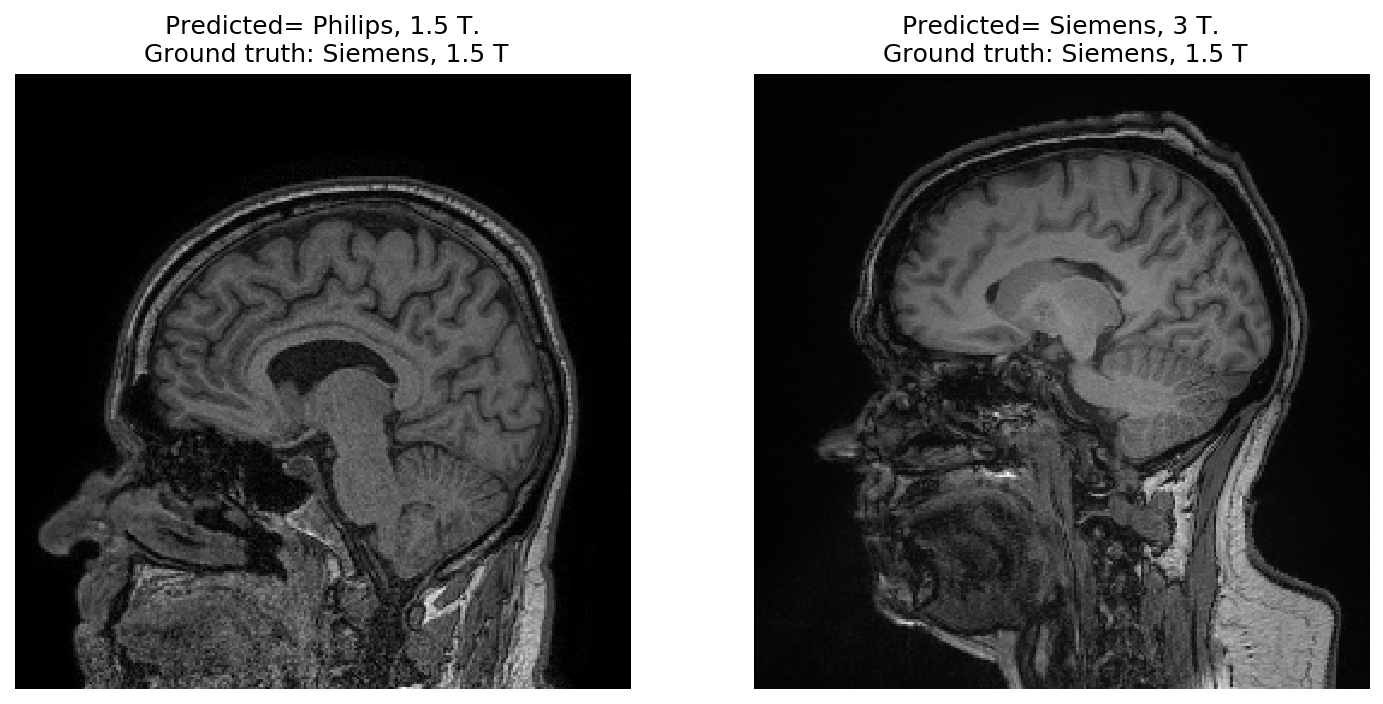

In [12]:
# Display some samples
mistakes = np.where(pred != labels_test)[0]
print(mistakes)
cols = 3
rows = np.ceil(mistakes.size/cols)

plt.figure(dpi = 150, figsize = (18,12))
counter = 1
for ii in mistakes:
    plt.subplot(rows,cols,counter)
    plt.imshow(samples_test[ii],cmap = "gray")
    plt.axis("off")
    plt.title("Predicted= %s, %s.\n Ground truth: %s, %s" %(vendor_dic[str(vendor_labels_test[ii])],\
                                                          field_dic[str(field_labels_test[ii])],\
                                                          vendor_dic[str(pred[ii]%3)],\
                                                          field_dic[str(pred[ii]//3)]))
    counter+=1
plt.show()